# 3. Feature Encoding
## 3.1 Dataset preparation

In [1]:
import sys
import os
os.environ["KERAS_BACKEND"] = "tensorflow"
kerasBKED = os.environ["KERAS_BACKEND"] 
import warnings
warnings.filterwarnings("ignore")
print(sys.version)

3.6.8 |Anaconda, Inc.| (default, Feb 21 2019, 18:30:04) [MSC v.1916 64 bit (AMD64)]


In [2]:
# import block
import tensorflow as tf
from keras import backend as K
from keras.datasets import cifar10
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from keras.layers import Conv2D, UpSampling2D, ZeroPadding2D, MaxPooling2D, Conv2DTranspose, MaxPool2D, Flatten, BatchNormalization
from keras.models import Model
from keras.layers import Reshape,Input, Dense, Dropout, Activation, Add, Concatenate
from keras.datasets import cifar10
from keras import regularizers
from keras.models import Model, Sequential
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping, TensorBoard
from keras.optimizers import SGD, Adam, RMSprop, Adadelta
from keras.preprocessing.image import ImageDataGenerator
from keras.utils import np_utils

from sklearn.utils import class_weight
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler, LabelBinarizer, RobustScaler, StandardScaler
import seaborn as sns

Using TensorFlow backend.


In [3]:
# The data, split between train and test sets:
(x_train, y_train), (x_test, y_test) = cifar10.load_data()
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')

50000 train samples
10000 test samples


In [4]:
x_train = x_train.astype('float32') / 255.0
x_test = x_test.astype('float32') / 255.0

In [5]:
x_train[0][0][0:3]

array([[0.23137255, 0.24313726, 0.24705882],
       [0.16862746, 0.18039216, 0.1764706 ],
       [0.19607843, 0.1882353 , 0.16862746]], dtype=float32)

In [6]:
# Checking the results
print("data type", type(x_train), type(x_test),type(y_train),type(y_test))
print('x_train shape:', x_train.shape)
print('y_train shape:', y_train.shape)
print('x_test shape:', x_test.shape)
print('y_test shape:', y_test.shape)

data type <class 'numpy.ndarray'> <class 'numpy.ndarray'> <class 'numpy.ndarray'> <class 'numpy.ndarray'>
x_train shape: (50000, 32, 32, 3)
y_train shape: (50000, 1)
x_test shape: (10000, 32, 32, 3)
y_test shape: (10000, 1)


In [7]:
y_train

array([[6],
       [9],
       [9],
       ...,
       [9],
       [1],
       [1]], dtype=uint8)

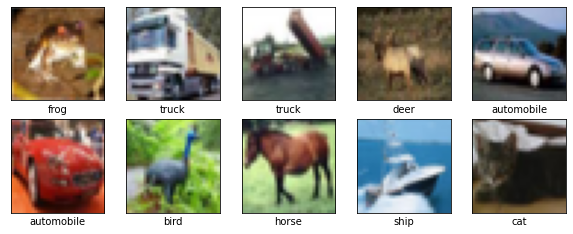

In [8]:
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer',
               'dog', 'frog', 'horse', 'ship', 'truck']

plt.figure(figsize=(10,10))
for i in range(10):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(x_train[i], cmap=plt.cm.binary)
    # The CIFAR labels happen to be arrays, 
    # which is why you need the extra index
    plt.xlabel(class_names[y_train[i][0]])
plt.show()

# Building Autoencoders

## basic model

In [ ]:
# the simplest model
def create_block(input, chs): ## Convolution block of 2 layers
    x = input
    for i in range(2):
        x =  Conv2D(chs, (3,3), activation='relu', padding='same')(x)
        x = BatchNormalization()(x)
    return x

def autoencoder1():
    input = Input((32,32,3))
    
    # Encoder
    block1 = create_block(input, 32)
    x = MaxPooling2D(2)(block1)
    block2 = create_block(x, 64)
    x = MaxPooling2D(2)(block2)
    
    #latent space

    middle = Dense(10)(x)
    
    # Decoder
    up1 = UpSampling2D((2,2))(middle)
    block3 = create_block(up1, 64)
    up2 = UpSampling2D((2,2))(block3)
    block4 = create_block(up2, 32)
    # output
    x = Conv2D(3, 1)(block4)
    output = Activation("sigmoid")(x)
    return Model(input, middle), Model(input, output)

In [21]:
# more complex
def create_block(input, chs): ## Convolution block of 2 layers
    x = input
    for i in range(1):
        x =  Conv2D(chs, (3,3), activation='relu', padding='same')(x)
        x = BatchNormalization()(x)
    return x

def autoencoder2():
    input = Input((32,32,3))
    
    # Encoder
    x = create_block(input, 8)
    x = MaxPooling2D((4,4))(x)
    x = create_block(x, 16)
    x = MaxPooling2D((4,4))(x)
    x = create_block(x, 32)
    x = MaxPooling2D((2,2))(x)
    
    x = Dense(24)(x)
    #latent space
    middle = Dense(10)(x)
    
    # Decoder
    x = Dense(24)(middle)
    x = UpSampling2D((2,2))(x)
    x = create_block(x, 32)
    x = UpSampling2D((4,4))(x)
    x = create_block(x, 16)
    x = UpSampling2D((4,4))(x)
    x = create_block(x, 8)
    # output
    x = Conv2D(3, 1)(x)
    output = Activation("sigmoid")(x)
    return Model(input, middle), Model(input, output)

In [22]:
# Parameters
learning_rate = 0.05
training_epochs = 100
batch_size = 512

In [23]:
encoder, model = autoencoder2()

In [24]:
model.compile(optimizer= "adam", loss='mse',metrics=['accuracy'])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 32, 32, 3)         0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 32, 32, 8)         224       
_________________________________________________________________
batch_normalization_7 (Batch (None, 32, 32, 8)         32        
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 8, 8, 8)           0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 8, 8, 16)          1168      
_________________________________________________________________
batch_normalization_8 (Batch (None, 8, 8, 16)          64        
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 2, 2, 16)          0         
__________

In [18]:
init_g = tf.global_variables_initializer()
init_l = tf.local_variables_initializer()
with tf.Session() as sess:
    sess.run(init_g)
    sess.run(init_l)
 

In [19]:
my_callbacks = [
    EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_delta=0.0001),
    ModelCheckpoint(filepath='D:/ProjectsFolder/mmbr',save_weights_only=True,monitor='val_acc',mode='max',save_best_only=True),
    TensorBoard(log_dir="./logs")
]
history = model.fit(x_train, x_train,
          batch_size= batch_size,
          epochs=training_epochs,
          shuffle=True,
          validation_data=(x_test, x_test),
                    callbacks = my_callbacks)

Train on 50000 samples, validate on 10000 samples
Epoch 1/100
13312/50000 [======>.......................] - ETA: 1:36 - loss: 0.0680 - acc: 0.3871

KeyboardInterrupt: 

## VGG16

In [31]:
from keras.engine.topology import Layer
from keras.layers import Reshape, Concatenate, Lambda, Multiply

class Unpooling(Layer):

    def __init__(self, orig, the_shape, **kwargs):
        self.orig = orig
        self.the_shape = the_shape
        super(Unpooling, self).__init__(**kwargs)

    def call(self, x):
        # here we're going to reshape the data for a concatenation:
        # xReshaped and origReshaped are now split branches
        shape = list(self.the_shape)
        shape.insert(0, 1)
        shape = tuple(shape)
        xReshaped = Reshape(shape)(x)
        origReshaped = Reshape(shape)(self.orig)

        # concatenation - here, you unite both branches again
        # normally you don't need to reshape or use the axis var,
        # but here we want to keep track of what was x and what was orig.
        together = Concatenate(axis=1)([origReshaped, xReshaped])

        bool_mask = Lambda(lambda t: K.greater_equal(t[:, 0], t[:, 1]),
                           output_shape=self.the_shape)(together)
        mask = Lambda(lambda t: K.cast(t, dtype='float32'))(bool_mask)

        x = Multiply()([mask, x])
        return x

In [86]:
def create_model():
    # Encoder
    input = Input(shape=(32,32,3))
    x = ZeroPadding2D((1, 1))(input)
    x = Conv2D(64, (3, 3), activation='relu', name='conv1_1')(x)
    x = ZeroPadding2D((1, 1))(x)
    x = Conv2D(64, (3, 3), activation='relu', name='conv1_2')(x)
    orig_1 = x
    x = MaxPooling2D((2, 2), strides=(2, 2))(x)

    x = ZeroPadding2D((1, 1))(x)
    x = Conv2D(128, (3, 3), activation='relu', name='conv2_1')(x)
    x = ZeroPadding2D((1, 1))(x)
    x = Conv2D(128, (3, 3), activation='relu', name='conv2_2')(x)
    orig_2 = x
    x = MaxPooling2D((2, 2), strides=(2, 2))(x)

    x = ZeroPadding2D((1, 1))(x)
    x = Conv2D(256, (3, 3), activation='relu', name='conv3_1')(x)
    x = ZeroPadding2D((1, 1))(x)
    x = Conv2D(256, (3, 3), activation='relu', name='conv3_2')(x)
    x = ZeroPadding2D((1, 1))(x)
    x = Conv2D(256, (3, 3), activation='relu', name='conv3_3')(x)
    orig_3 = x
    x = MaxPooling2D((2, 2), strides=(2, 2))(x)

    x = ZeroPadding2D((1, 1))(x)
    x = Conv2D(512, (3, 3), activation='relu', name='conv4_1')(x)
    x = ZeroPadding2D((1, 1))(x)
    x = Conv2D(512, (3, 3), activation='relu', name='conv4_2')(x)
    x = ZeroPadding2D((1, 1))(x)
    x = Conv2D(512, (3, 3), activation='relu', name='conv4_3')(x)
    orig_4 = x
    x = MaxPooling2D((2, 2), strides=(2, 2))(x)

    x = ZeroPadding2D((1, 1))(x)
    x = Conv2D(512, (3, 3), activation='relu', name='conv5_1')(x)
    x = ZeroPadding2D((1, 1))(x)
    x = Conv2D(512, (3, 3), activation='relu', name='conv5_2')(x)
    x = ZeroPadding2D((1, 1))(x)
    x = Conv2D(512, (3, 3), activation='relu', name='conv5_3')(x)
   
    orig_5 = x
    x = MaxPooling2D((2, 2), strides=(2, 2))(x)
    
    
   
    middle = Dense(10)(x)
    # Decoder

    x = Conv2D(512, (1, 1), activation='relu', padding='same', name='deconv6', kernel_initializer='he_normal',
               bias_initializer='zeros')(middle)
    
    x = BatchNormalization()(x)
    x = UpSampling2D(size=(2, 2))(x)
    x = Unpooling(orig_5, (2, 2, 512))(x)
    
    x = Conv2D(512, (5, 5), activation='relu', padding='same', name='deconv5', kernel_initializer='he_normal',
               bias_initializer='zeros')(x)
    x = BatchNormalization()(x)
    x = UpSampling2D(size=(2, 2))(x)
    
    x = Unpooling(orig_4, (4, 4, 512))(x)

    x = Conv2D(256, (5, 5), activation='relu', padding='same', name='deconv4', kernel_initializer='he_normal',
               bias_initializer='zeros')(x)
    x = BatchNormalization()(x)
    x = UpSampling2D(size=(2, 2))(x)
    
    x = Unpooling(orig_3, (8, 8, 256))(x)

    x = Conv2D(128, (5, 5), activation='relu', padding='same', name='deconv3', kernel_initializer='he_normal',
               bias_initializer='zeros')(x)
    x = BatchNormalization()(x)
    x = UpSampling2D(size=(2, 2))(x)
    x = Unpooling(orig_2, (16, 16, 128))(x)

    x = Conv2D(64, (5, 5), activation='relu', padding='same', name='deconv2', kernel_initializer='he_normal',
               bias_initializer='zeros')(x)
    x = BatchNormalization()(x)
    x = UpSampling2D(size=(2, 2))(x)
    x = Unpooling(orig_1, (32, 32, 64))(x)

    x = Conv2D(64, (5, 5), activation='relu', padding='same', name='deconv1', kernel_initializer='he_normal',
               bias_initializer='zeros')(x)
    x = BatchNormalization()(x)
    output = Conv2D(3, (5, 5), activation='sigmoid', padding='same', name='pred', kernel_initializer='he_normal',
               bias_initializer='zeros')(x)
    return Model(input,middle), Model(input, output)

In [87]:
encoder, model = create_model()

In [88]:
# Parameters
learning_rate = 0.1
training_epochs = 5
batch_size = 512


In [ ]:
# model.compile(SGD(1e-3, 0.9), loss=loss_function)
model.compile(optimizer=SGD(1e-3, 0.9), loss='mean_squared_error',metrics=['accuracy'])
model.summary()

In [ ]:
# er = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
# lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_delta=0.0001)
# callbacks = [er, lr]

my_callbacks = [
    EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_delta=0.0001),
#     TensorBoard(log_dir='./autoencoder'),
]

history = model.fit(x_train, x_train,
          batch_size= batch_size,
          epochs=training_epochs,
          shuffle=True,
          validation_data=(x_test, x_test),
                    callbacks = my_callbacks)

## export model

In [17]:
from keras.utils.vis_utils import model_to_dot
import pydot
model_to_dot(model,
    show_shapes=False,
    show_layer_names=True,
    rankdir="TB",)
#     expand_nested=False,
#     dpi=96,
#     subgraph=False)

# results visualization

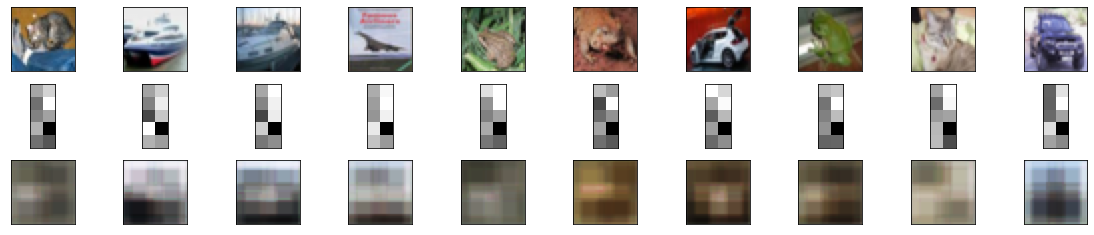

In [15]:
encoded_imgs = encoder.predict(x_test)
reconstructed_img = model.predict(x_test)
plt.figure(figsize=(40, 4))
for i in range(10):
    # display original images
    ax = plt.subplot(3, 20, i + 1)
    plt.imshow(x_test[i].reshape(32,32,3))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    
    # display encoded images
    ax = plt.subplot(3, 20, i + 1 + 20)
#     .reshape([encoded_imgs.shape[-1]//2,-1])
    plt.imshow(encoded_imgs[i].reshape([encoded_imgs.shape[-1]//2,-1]))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
# display reconstructed images
    ax = plt.subplot(3, 20, 2*20 +i+ 1)
    plt.imshow(reconstructed_img[i].reshape(32, 32,3))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
  
    
plt.show()

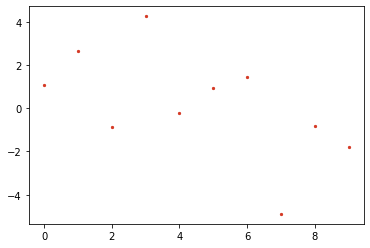

In [25]:
# transform each input image into the latent space
z = encoder.predict(x_test)
# plot the latent space
plt.scatter(range(10),z[0], marker='o', s=5, c='#d53a26')
plt.show()

In [26]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='lower right')
plt.show()

NameError: name 'history' is not defined

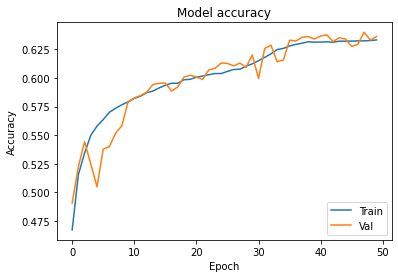

In [103]:
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='lower right')
plt.show()

In [116]:
print("Average test loss: ", np.average(history.history['loss']))

Average test loss:  0.03427278531832695


# Analyzing the Trained Autoencoder

In [117]:
import matplotlib.pyplot as plt

# transform each input image into the latent space
z = encoder.predict(x_train)

# plot the latent space
plt.scatter(z[:,0], z[:,1], marker='o', s=0.1, c='#d53a26')
plt.show()

IndexError: index 1 is out of bounds for axis 1 with size 1

Sampling from the Latent Space

In [ ]:
# sample from the region 10, 50 in the latent space
y = np.array([[12,43,78,23,56,89,54,78,2,9]])
prediction = model.predict(y)
plt.imshow(prediction.squeeze(), cmap='gray')

In [ ]:
plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(x_train[i], cmap=plt.cm.binary)
    # The CIFAR labels happen to be arrays, 
    # which is why you need the extra index
    plt.xlabel(class_names[y_train[i][0]])
plt.show()